In [1]:
#importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data=pd.read_csv("/content/Light_Rail_Patronage.csv")

In [3]:
data

,Date,MyWay,Paper Ticket,Total
0,22-04-2019,4075,1418,5493
1,23-04-2019,8134,1018,9152
2,24-04-2019,9518,1147,10665
3,25-04-2019,4866,1313,6179
4,26-04-2019,9074,1143,10217
...,...,...,...,...
1337,21-12-2022,9707,526,10233
1338,22-12-2022,8354,464,8818
1339,23-12-2022,8260,596,8856
1340,24-12-2022,4353,337,4690


In [4]:
# Convert Month into Datetime
data['Date']=pd.to_datetime(data['Date'])

In [5]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


Check both the features whether they are stationary or not.

In [6]:
adf_test(data['MyWay'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.384059
p-value                    0.011514
# lags used               21.000000
# observations          1320.000000
critical value (1%)       -3.435314
critical value (5%)       -2.863732
critical value (10%)      -2.567937
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [7]:
adf_test(data['Paper Ticket'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.040961
p-value                    0.031242
# lags used               21.000000
# observations          1320.000000
critical value (1%)       -3.435314
critical value (5%)       -2.863732
critical value (10%)      -2.567937
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [8]:
adf_test(data['Total'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.318371
p-value                    0.014077
# lags used               21.000000
# observations          1320.000000
critical value (1%)       -3.435314
critical value (5%)       -2.863732
critical value (10%)      -2.567937
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


All the three features are stationary

In [9]:
#set Date column as an index
data.set_index('Date',inplace=True)

In [10]:
data.head()

,MyWay,Paper Ticket,Total
Date,,,
2019-04-22,4075,1418,5493
2019-04-23,8134,1018,9152
2019-04-24,9518,1147,10665
2019-04-25,4866,1313,6179
2019-04-26,9074,1143,10217


In [11]:
np.asarray(data)

array([[ 4075,  1418,  5493],
       [ 8134,  1018,  9152],
       [ 9518,  1147, 10665],
       ...,
       [ 8260,   596,  8856],
       [ 4353,   337,  4690],
       [ 1169,    53,  1222]])

Train-Validation Split

Creating a validation set for time series problems is tricky because we have to take into account the time component. One cannot directly use the `train_test_split` or k-fold validation since this will disrupt the pattern in the series. The validation set should be created considering the date and time values.

In [12]:
train = data[:int(0.70*(len(data)))]
valid = data[int(0.30*(len(data))):]
train


,MyWay,Paper Ticket,Total
Date,,,
2019-04-22,4075,1418,5493
2019-04-23,8134,1018,9152
2019-04-24,9518,1147,10665
2019-04-25,4866,1313,6179
2019-04-26,9074,1143,10217
...,...,...,...
2021-12-11,6582,258,6840
2021-11-13,3705,319,4024
2021-11-14,2496,159,2655


Vector Autoregression (VAR)

In [13]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [14]:
# Fit the model
model = VAR(endog=train, freq=None, missing='none')
model_fit = model.fit()

# Make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [15]:
#model_fit.summary()

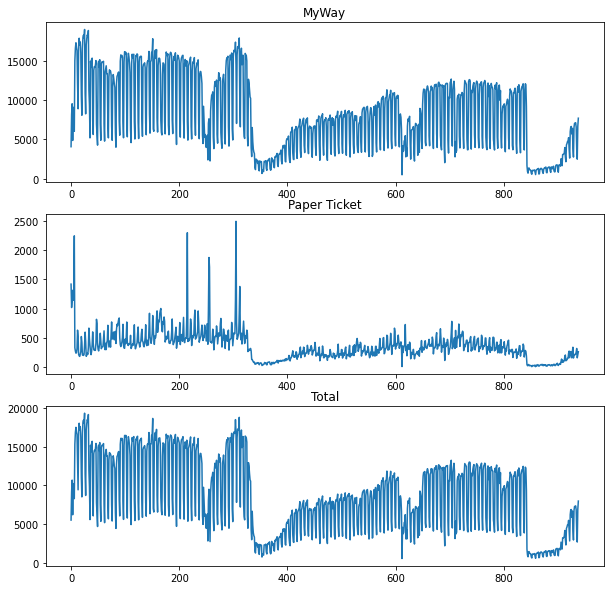

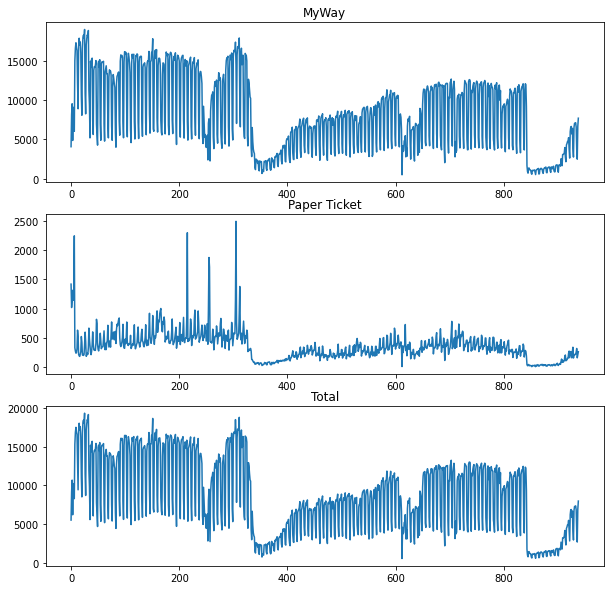

In [16]:
model_fit.plot()

In [17]:
lag_order = model_fit.k_ar

In [18]:
model_fit.forecast(data.values[-lag_order:], 5)

array([[3230.93964983,   62.53846409, 3293.47811393],
       [4800.19538277,  102.41523386, 4902.61061662],
       [5951.57714228,  151.58148089, 6103.15862316],
       [6770.16768793,  199.14080834, 6969.30849627],
       [7335.5735322 ,  240.22523145, 7575.79876364]])

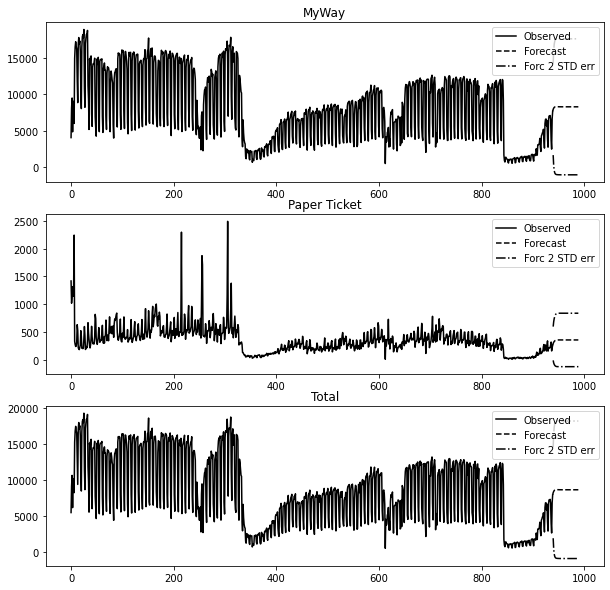

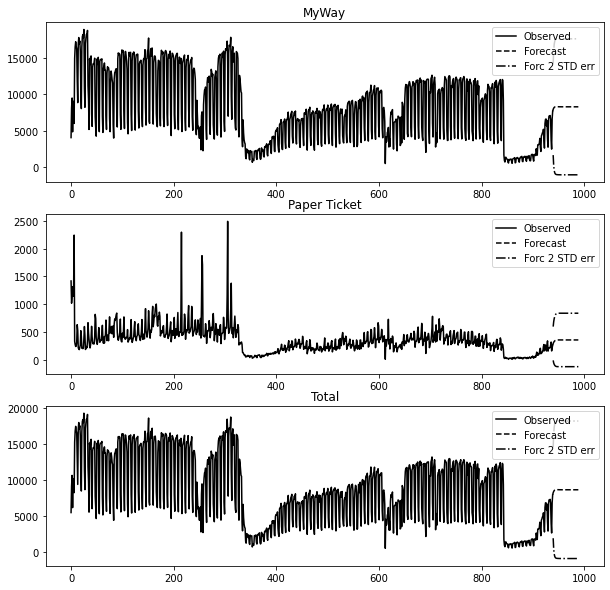

In [19]:
model_fit.plot_forecast(50)

In [20]:
# Convert array to DataFrame
cols = data.columns
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])

for j in range(0, len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

In [21]:
# RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
for i in cols:
    print('RMSE value for', i, 'is:', sqrt(mean_squared_error(pred[i], valid[i])))

RMSE value for MyWay is: 3567.8377763620365
RMSE value for Paper Ticket is: 184.6940001375701
RMSE value for Total is: 3650.6743265404866


PREDICTIONS:

7-Days

In [22]:
# Make final predictions
model = VAR(endog=data)
model_fit = model.fit()

yhat = model_fit.forecast(model_fit.y, steps=7)
yhat=pd.DataFrame(yhat, columns=["MyWay","Paper Ticket","Total"])
yhat

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,MyWay,Paper Ticket,Total
0,3585.038565,80.194724,3665.233288
1,5341.974031,138.192306,5480.166337
2,6543.432347,200.308734,6743.741081
3,7320.278564,254.501624,7574.780188
4,7794.614806,296.861257,8091.476063
5,8065.765050,327.561942,8393.326993
6,8207.838206,348.495647,8556.333853


14-days

In [23]:
yhat = model_fit.forecast(model_fit.y, steps=14)
yhat=pd.DataFrame(yhat, columns=["MyWay","Paper Ticket","Total"])
yhat

/usr/local/lib/python3.8/dist-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,MyWay,Paper Ticket,Total
0,3585.038565,80.194724,3665.233288
1,5341.974031,138.192306,5480.166337
2,6543.432347,200.308734,6743.741081
3,7320.278564,254.501624,7574.780188
4,7794.614806,296.861257,8091.476063
5,8065.765050,327.561942,8393.326993
6,8207.838206,348.495647,8556.333853
7,8272.617728,361.993245,8634.610973
8,8294.276437,370.209767,8664.486203
9,8294.136147,374.889174,8669.025321


30-Days

In [24]:
yhat = model_fit.forecast(model_fit.y, steps=30)
yhat=pd.DataFrame(yhat, columns=["MyWay","Paper Ticket","Total"])
yhat

/usr/local/lib/python3.8/dist-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,MyWay,Paper Ticket,Total
0,3585.038565,80.194724,3665.233288
1,5341.974031,138.192306,5480.166337
2,6543.432347,200.308734,6743.741081
3,7320.278564,254.501624,7574.780188
4,7794.614806,296.861257,8091.476063
5,8065.765050,327.561942,8393.326993
6,8207.838206,348.495647,8556.333853
7,8272.617728,361.993245,8634.610973
8,8294.276437,370.209767,8664.486203
9,8294.136147,374.889174,8669.025321
